In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

# Analyze robustness test

In [156]:
class RobustTest:

    '''
    analyze data from robustness test

    methods
    categorize_value : categorize genes based on their fdr values
    plotcat : generate heatmap with categorized data
    heatmap : import data from given repository & iterate plotcat 
    sort_val : calculate tpr, fpr, common number of genes under selection
    plot : plot the values from sort_val
    '''

    def __init__(self,
                 original,
                 species,
                 directory
                 ):
        
        '''
        Arguments
        oritinal(DataFrame) : original ou result
        species(DataFrame) : containing information of deleted species at each datasets
        directory(str) : ou result dataset directory, each dataset should contain qvalues column and gene_names for rownames
        '''

        # original data
        self.original = original.sort_values(by="qvalues")
        self.original_idx = self.original["gene_name"]

        self.species = species
        self.directory = directory
        self.db = {}


    def categorize_value(self, value):
        ## categorize fdr value 
        if value <= 0.05:
            return 'selection'
        elif value > 0.05:
            return 'drift'
        else:
            return 'None'
        
    
    def plotcat(self, cat, title):
        # Define a mapping dictionary for categorical to numerical values
        cat_mapping = {
            "selection": 0,
            "None": 1,
            "drift": 2
        }

        # Convert categorical values to numerical values
        numerical_df = cat.replace(cat_mapping)

        # discrete colormap (n samples from a given cmap)
        colors = ["#FFC1C1","#D3D3D3", "#C1C1FF"]
        cmap = sns.color_palette(colors, as_cmap=True)
        ax = sns.heatmap(numerical_df, cmap=cmap) 

        # Get the colorbar
        colorbar = ax.collections[0].colorbar

        # Set the tick positions and labels
        tick_positions = [1/3, 1, 5/3]
        tick_labels = ["stabilizing selection","None", "neutral evolution"]

        # Set the tick positions and labels on the colorbar
        colorbar.set_ticks(tick_positions)
        colorbar.set_ticklabels(tick_labels)  

        #directory = "/Users/yunseong-eun/Desktop/processed_chen/Robustness_byspecies/result/"+title+".png"
        #print(directory)
        #plt.savefig(directory)
        plt.show()
    

    def heatmap(self):
        # import data from directory & iterate plotcat
        for s, sim in enumerate(self.species.columns):
            directory = f"{self.directory}{s+1}_sim/"
            df = {}
            for i in self.species[sim]:
                df[i] = pd.read_csv(directory+i+".txt",delimiter="\t", index_col = 0)
                df[i] = df[i].reindex(self.original_idx)

            cat = {}
            cat["original"] = self.original['qvalues'].apply(self.categorize_value).tolist()
            for i in self.species[sim]:
                cat[i] = df[i]['qvalues'].apply(self.categorize_value).tolist()
            cat = pd.DataFrame(cat)
            cat.index = self.original_idx
            self.db[s] = cat
            
            self.plotcat(cat = cat, title = f"cat_{sim}")
        return self.db


    def sort_val(self):
        # generate dictionaries : df, FPR, TPR, TP, tt, ff

        df = {}   # number of genes under selection
        FPR = {}  # FP / (FP + TN)
        TPR = {}  # TP / (TP _ FN)
        TP = {}   # TP 
        tt = {}   # number of genes under selection
        ff = {}   # number of genes under drift

        true = self.db[0][self.db[0]["original"] == "selection"].index.tolist()
        false = self.db[0][self.db[0]["original"] == "drift"].index.tolist()

        for i in range(1, len(self.db[0].columns)):
            df[17-i] = []
            FPR[17-i] = []
            TPR[17-i] = []
            TP[17-i] = []
            tt[17-i] = []
            ff[17-i] = []

            for j in self.db.keys():
                # number of genes under selection in ith dataset in each db keys
                df[17-i].append(np.sum(self.db[j].iloc[:,i] == "selection"))

                positive = self.db[j][self.db[j].iloc[:,i]=="selection"].index.tolist()
                negative = self.db[j][self.db[j].iloc[:,i]=="drift"].index.tolist()
                tt[17-i].append(len(positive))
                ff[17-i].append(len(negative))

                # fpr
                if len(negative) == 0:
                    FPR[17-i].append(None)
                else:
                    fp = set(false) & set(positive)
                    tn = set(true) & set(negative)
                    FPR[17-i].append(len(fp) / (len(fp)+len(tn)))

                # tpr
                if len(positive) == 0:
                    TPR[17-i].append(0)
                    TP[17-i].append(0)
                else:
                    tp = set(true) & set(positive)
                    fn = set(false) & set(negative)
                    TPR[17-i].append(len(tp) / (len(tp)+len(fn)))
                    TP[17-i].append(len(tp))

        return df, FPR, TPR, TP, tt, ff
    

    def plot(self) : 

        # get values
        df, FPR, TPR, TP, tt, ff = self.sort_val()

        ## number of genes under stabilizing selection ------------------------------------------------------------
        num = len(self.db[0][self.db[0]["original"] == "selection"].index.tolist())
        plt.boxplot(df.values(), labels=df.keys())
        plt.xticks(range(1, len(df.keys()) + 1), df.keys(), rotation=90)
        plt.xlabel('number of species')
        plt.ylabel('number of genes with low fdr value')
        plt.title('Robustness test, '+f', {num} genes in whole species')
        horizontal_line_value = num
        plt.axhline(y = num, color='b', linestyle='--')
        plt.show()

        ## FPR -------------------------------------------------------------------------------------------------
        mean_fpr = []
        std_fpr = []

        for i in FPR.keys():
            fpr = pd.Series(FPR[i])
            mean_fpr.append(fpr.mean(skipna=True))
            std_fpr.append(fpr.std(skipna=True))

        print(mean_fpr)
        print(std_fpr)
        x = np.arange(len(FPR.keys()))
        plt.errorbar(x, mean_fpr, yerr=std_fpr, fmt='o')
        plt.xticks(range(len(df.keys())), df.keys(), rotation=90)
        plt.xlabel("number of species")
        plt.ylabel('Mean FPR')
        plt.title('Robustness test, fpr')
        plt.show()

        ## TPR -------------------------------------------------------------------------------------------------
        mean_tpr = []
        std_tpr = []

        for i in TPR.keys():
            tpr = pd.Series(TPR[i])
            mean_tpr.append(tpr.mean(skipna=True))
            std_tpr.append(tpr.std(skipna=True))

        print(mean_tpr)
        print(std_tpr)
        plt.errorbar(x, mean_tpr, yerr=std_tpr, fmt='o')
        plt.xticks(range(len(df.keys())), df.keys(), rotation=90)
        plt.xlabel("number of species")
        plt.ylabel('Mean TPR')
        plt.title('Robustness test, TPR')
        plt.show()

        ## common genes ----------------------------------------------------------------------------------------
        mean = []
        std = []

        for i in TP.keys():
            tp = pd.Series(TP[i])
            mean.append(tp.mean(skipna=False))
            std.append(tp.std(skipna=False))

        plt.errorbar(x, mean, yerr=std, fmt='o')
        plt.xticks(range(len(df.keys())), df.keys(), rotation=90)
        plt.xlabel("number of species")
        plt.ylabel('Mean ratio')
        plt.title('Robustness test, common genes, TP/true')
        plt.show()

        ## ratio of categories --------------------------------------------------------------------------------
        feature1 = [np.mean(value) for key, value in tt.items()]
        feature2 = [np.mean(value) for key, value in ff.items()]

        plt.bar(x, feature1, label='stabilizing selection')
        plt.bar(x, feature2, bottom=feature1, label='neutral drift')
        plt.xticks(range(len(df.keys())), df.keys(), rotation=90)
        plt.xlabel("number of species")
        plt.ylabel('mean number of genes')
        plt.title('Robustness test, proportion of genes')

        plt.legend()
        plt.show()

# input data

In [5]:
# original data
original = pd.read_csv("/Users/yunseong-eun/Desktop/processed_chen/subset/subset_OU/liver.txt", delimiter = "\t")
original

,Unnamed: 0,gene_name,qvalues,thetas,var,alphas,sigmas,logLik,brownSigmas
0,0,NFYA,1.811676e-06,0.750416,0.029203,1893.608838,110.596841,3.809598,2.530226
1,1,IBTK,2.995344e-02,1.190873,0.056991,13.772426,1.569808,1.738785,0.505616
2,2,IFI35,2.842793e-05,1.388878,0.022120,2928.252017,129.543072,5.357046,0.998536
3,3,TAL1,1.158284e-06,-0.136746,0.122821,1814.081318,445.614027,-4.039508,11.878824
4,4,ELAVL4,5.445580e-03,-1.507764,0.329612,19.289486,12.716085,-8.228334,4.193731
...,...,...,...,...,...,...,...,...,...
10893,10893,ZFPL1,7.436056e-07,1.167777,0.028952,1464.872659,84.820770,3.897919,3.182913
10894,10894,RPS6KA4,1.447188e-06,0.860749,0.025435,1434.085716,72.950897,4.153256,3.052140
10895,10895,LRP5,4.005784e-04,1.628711,0.116700,128.495690,29.990870,-3.625792,2.985312
10896,10896,FGF19,4.477792e-06,-1.786341,0.125886,2073.998789,522.173891,-4.231465,8.681156


In [6]:
# species matrix
species = pd.read_csv("/Users/yunseong-eun/Desktop/processed_chen/Robustness_byspecies/species.txt", delimiter = "\t")
species = species.drop("Unnamed: 0", axis=1)
species

,1_sim,2_sim,3_sim,4_sim,5_sim,6_sim,7_sim,8_sim,9_sim,10_sim
0,bonobo,rabbit,gorilla,rhesus,musMusculus,cow,musCaroli,marmoset,dog,musSpretus
1,human,gorilla,orangutan,rabbit,rabbit,chimp,armadillo,ferret,ferret,chimp
2,musMusculus,rhesus,bonobo,musCaroli,rat,opossum,marmoset,chimp,rhesus,gorilla
3,rabbit,musMusculus,ferret,dog,opossum,orangutan,orangutan,dog,chimp,opossum
4,marmoset,cow,opossum,gorilla,cow,rat,chimp,rabbit,rat,dog
5,ferret,armadillo,rabbit,cow,marmoset,ferret,dog,musSpretus,cow,bonobo
6,gorilla,bonobo,musMusculus,chimp,dog,rhesus,opossum,musMusculus,bonobo,marmoset
7,rhesus,opossum,musCaroli,rat,musCaroli,human,human,armadillo,orangutan,rhesus
8,dog,musSpretus,cow,musSpretus,orangutan,gorilla,ferret,human,musMusculus,cow
9,chimp,marmoset,armadillo,musMusculus,musSpretus,musCaroli,rhesus,rhesus,rabbit,ferret


In [7]:
directory = "/Users/yunseong-eun/Desktop/processed_chen/Robustness_byspecies/liver/"


# test

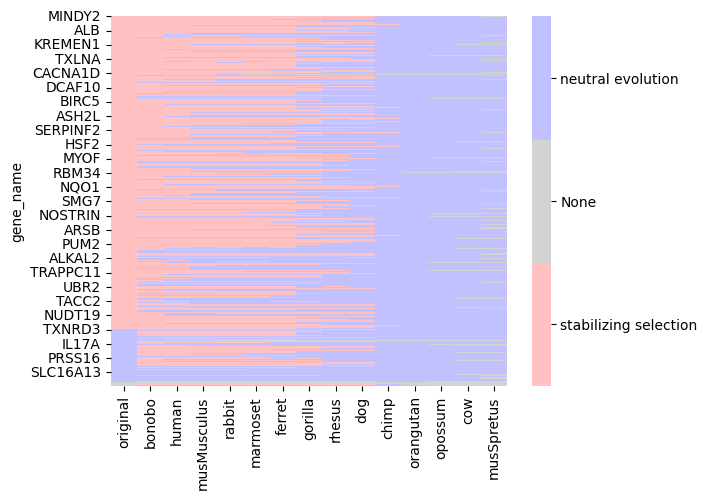

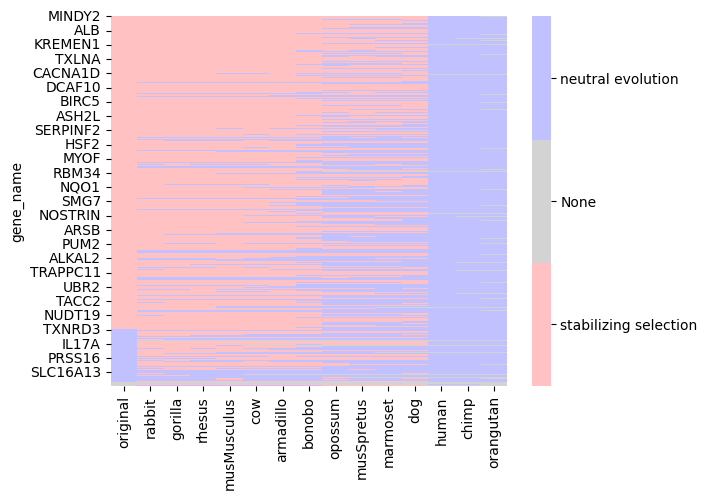

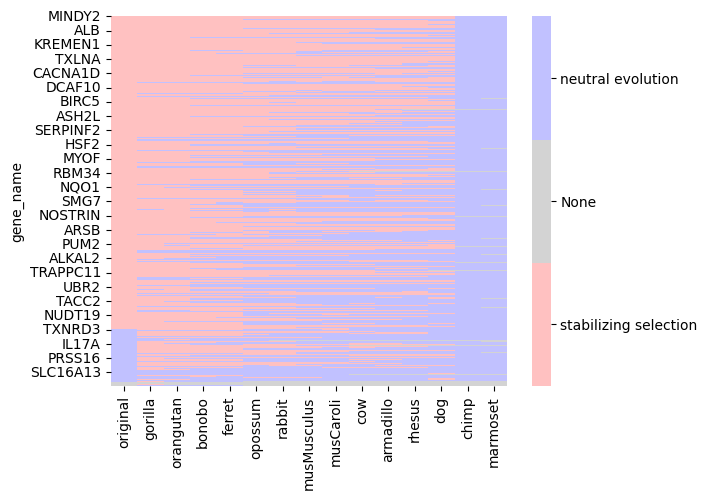

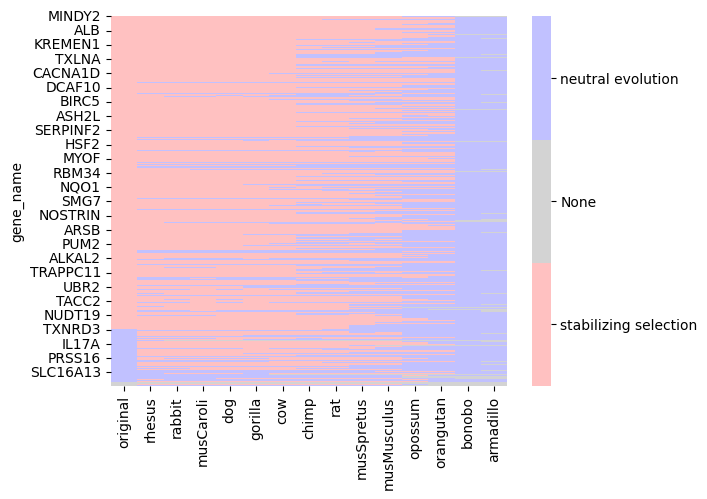

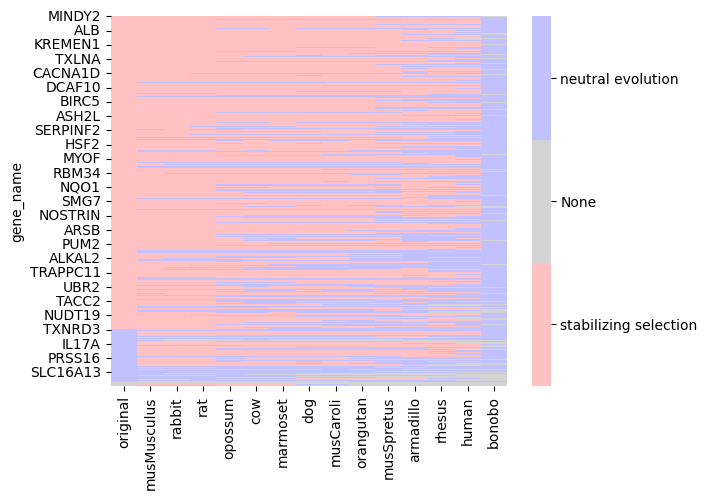

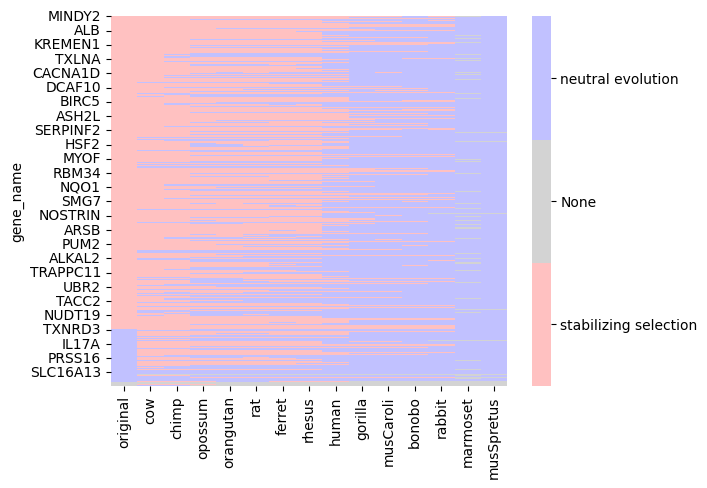

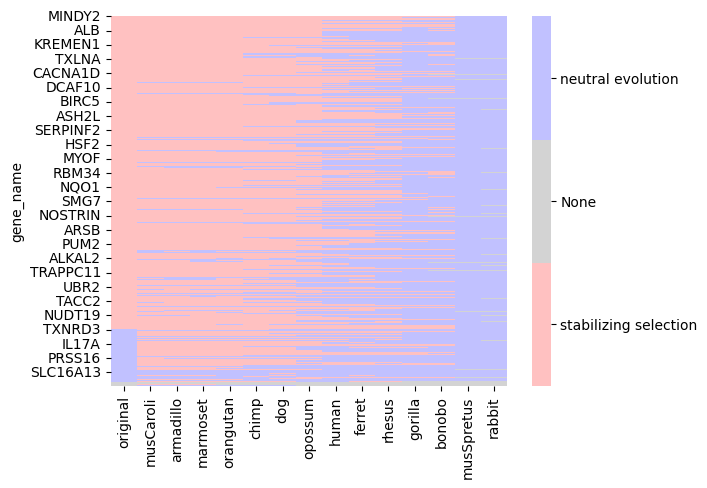

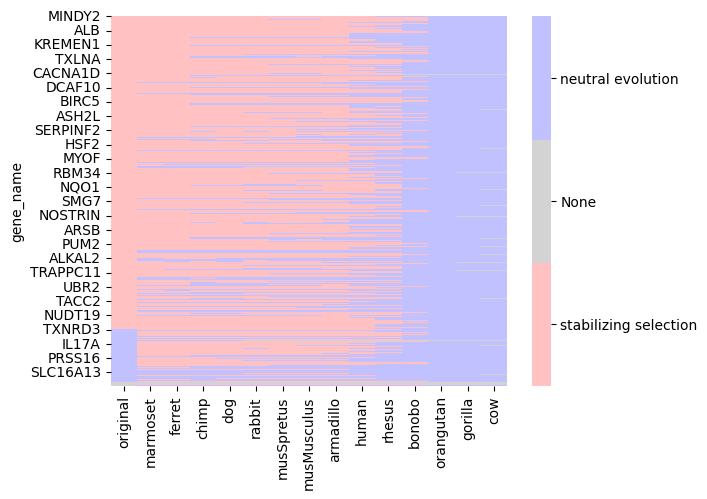

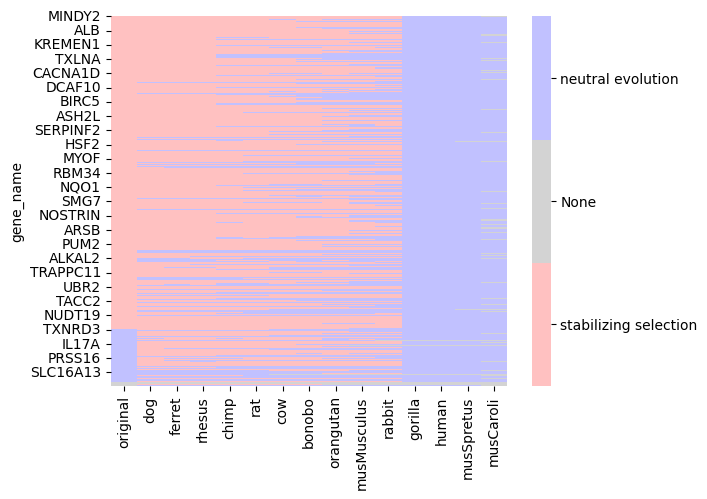

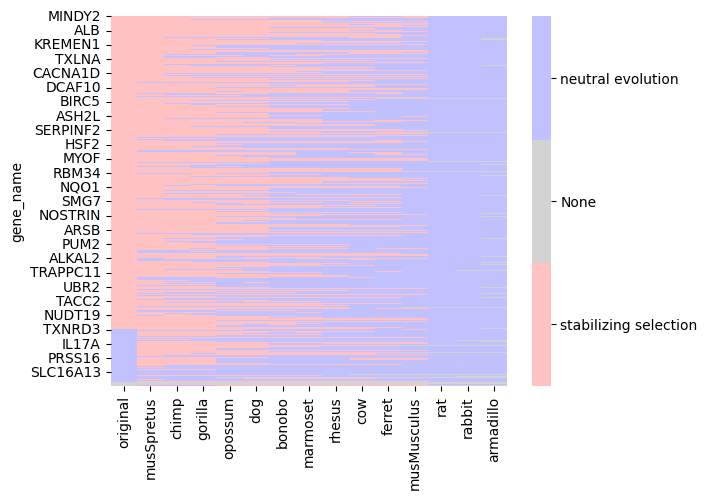

{0:             original     bonobo      human musMusculus     rabbit   marmoset   
 gene_name                                                                      
 MINDY2     selection  selection  selection   selection  selection  selection  \
 ELMSAN1    selection  selection  selection   selection  selection  selection   
 CD3EAP     selection  selection  selection   selection  selection  selection   
 IRF2BPL    selection  selection  selection   selection  selection  selection   
 MLH3       selection  selection  selection   selection  selection  selection   
 ...              ...        ...        ...         ...        ...        ...   
 PTH             None       None       None        None       None       None   
 PANX3           None  selection  selection   selection  selection  selection   
 CLDN17          None       None       None        None       None       None   
 HOXB13          None  selection       None        None       None       None   
 GIP             None  se

In [157]:
r = RobustTest(original = original, species = species, directory = directory)
db = r.heatmap()
db

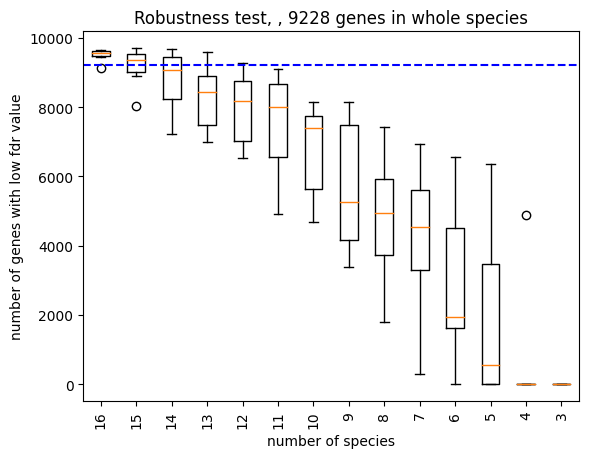

[0.5760055426979905, 0.5075228046357151, 0.4270551705906884, 0.3578918636584627, 0.3027766980235972, 0.27472222173069694, 0.19692658915202904, 0.14754958586086198, 0.10425862022886498, 0.08522323471791297, 0.049996064116431406, 0.030718254001438704, 0.008915211970074813, 0.0]
[0.041464155776764794, 0.1021162127580887, 0.14884822260347985, 0.1526769990888528, 0.12869129634037244, 0.13158860984044413, 0.08823848130991534, 0.1001373045473758, 0.06332862455155076, 0.05875858208263288, 0.051971141957232105, 0.0487663181413142, 0.028192375648633305, 0.0]


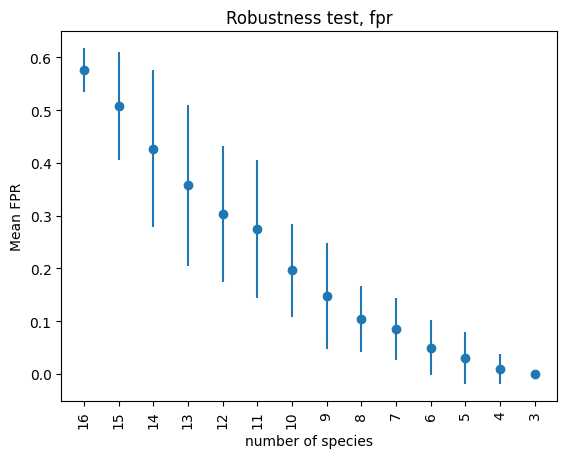

[0.9447120185989902, 0.9365242521292616, 0.9244720592276824, 0.9126281103330814, 0.9025907050369704, 0.8918706072490629, 0.8686034728650899, 0.8242044574646968, 0.7840806366558899, 0.7096542323525143, 0.5477114478075708, 0.34324266913690915, 0.08646135967460779, 0.0]
[0.003624930209841248, 0.012250107905468703, 0.02270143784353197, 0.027251807146640706, 0.029798100778252914, 0.04294004481305469, 0.05002980361369773, 0.07731344436255791, 0.10488569139082704, 0.227308457742723, 0.31694035550738686, 0.3810789416015299, 0.27341482616679536, 0.0]


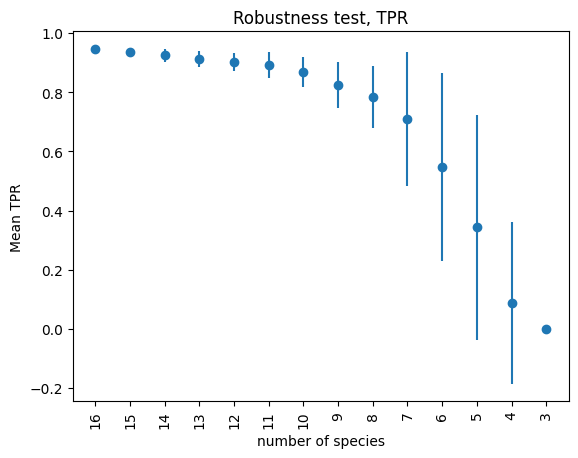

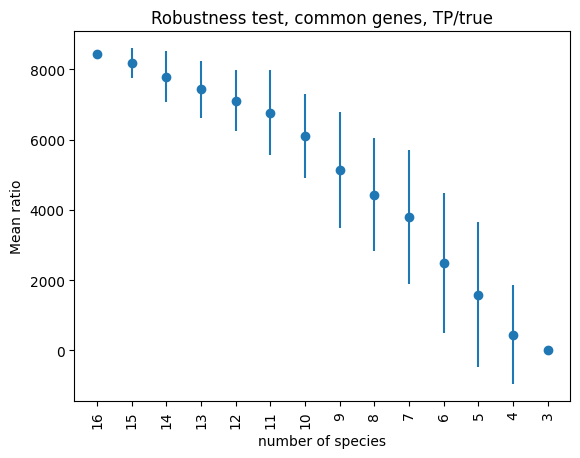

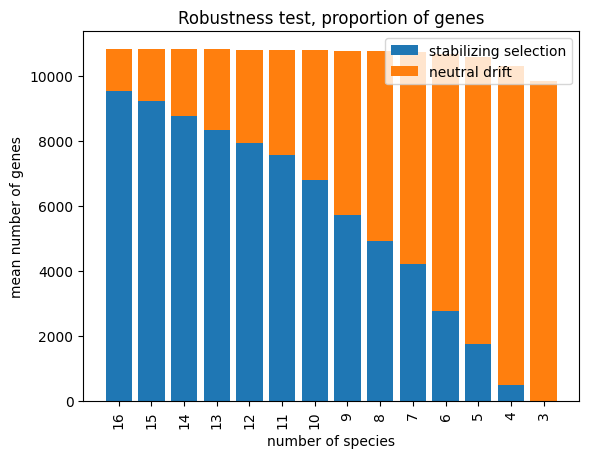

In [158]:
r.plot()